In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from scipy import linalg
from tqdm import tqdm

In [ ]:
# !pip uninstall cupy-cuda110 cupy-cuda12x
# !pip install cupy-cuda110
# import cupy as cp

In [ ]:
large_data = True
if large_data:
  !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
  !unzip ml-25m.zip
  path = "ml-25m/"
else:
  !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
  !unzip ml-latest-small.zip
  path = "ml-latest-small/"

--2024-05-15 19:20:36--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M   122MB/s    in 2.1s    

2024-05-15 19:20:39 (122 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


# Datasets

In [ ]:
large_data = True
if large_data:
    path = "ml-25m/"
else:
    path = "ml-latest-small/"

In [ ]:
movies = pd.read_csv(path + "movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
# movies["movieId"].max()

In [ ]:
# movies[movies["title"] == "Lord of the Rings, The (1978)"]['movieId']

In [ ]:
print("Number of movies : ",movies.shape[0])
genres = '|'.join(list(movies["genres"])).split("|")
print("Number of genres : ",len(set(genres)))
print(f"Many of the movies have the genre {max(genres)}")

Number of movies :  62423
Number of genres :  20
Many of the movies have the genre Western


In [ ]:
tags = pd.read_csv(path + "tags.csv")

In [ ]:
print("Number of tags : ", tags.shape[0])
u_id, counts = np.unique(tags.userId.values, return_counts=True)
print(f"The higher number of tags is {np.max(counts)} and come from the user {u_id[np.argmax(counts)]}")
print(f"The lower number of tags is {np.min(counts)} and come from the user {u_id[np.argmin(counts)]}")
del u_id, counts
m_id, counts = np.unique(tags.movieId.values, return_counts=True)
print(f"The movie the most tagged is {m_id[np.argmax(counts)]} and has been tagged {max(counts)} times")
print(f"The movie the least tagged is {m_id[np.argmin(counts)]} and has been tagged {min(counts)} times")
del m_id, counts

Number of tags :  1093360
The higher number of tags is 183356 and come from the user 6550
The lower number of tags is 1 and come from the user 20
The movie the most tagged is 260 and has been tagged 6180 times
The movie the least tagged is 109 and has been tagged 1 times


In [ ]:
ratings = pd.read_csv(path + "ratings.csv")
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


In [ ]:
u_id, counts = np.unique(ratings.userId.values, return_counts=True)
print("The number of users rated a movie is ",len(u_id))
print(f"The user rated the most of movies is {u_id[np.argmax(counts)]} and has rated {np.max(counts)}")
print(f"The user ids are numberred from {min(u_id)} to {max(u_id)}")
del u_id, counts

m_id, counts = np.unique(ratings.movieId.values, return_counts=True)
print("The number of movies rated is : ",len(m_id))
print(f"The movie the most rated is {m_id[np.argmax(counts)]} and has been rated {np.max(counts)} times")
del m_id, counts
print(f"The mean of ratings is : {ratings.rating.values.mean()}")
print(f"The small rating is {np.min(ratings.rating.values)}")
print(f"The bigger rating is {np.max(ratings.rating.values)}")

The number of users rated a movie is  162541
The user rated the most of movies is 72315 and has rated 32202
The user ids are numberred from 1 to 162541
The number of movies rated is :  59047
The movie the most rated is 356 and has been rated 81491 times
The mean of ratings is : 3.533854451353085
The small rating is 0.5
The bigger rating is 5.0


## Data Indexing

In [ ]:
ratings = ratings.values

In [ ]:
M = len(np.unique(ratings[:,0]))
N = len(np.unique(ratings[:,1]))

In [ ]:
#@title Indexing the whole dataset
movie_to_id = {}#dictionary
id_to_movie = []
user_to_id = {}#dictionary
id_to_user = []
data_by_user = []
data_by_movie = []

for i in tqdm(range(ratings.shape[0])):
  u_id = ratings[i,0]
  #check if u_id is already in user_to_id
  if not u_id in user_to_id.keys():
    user_to_id[u_id] = len(user_to_id)
    id_to_user.append(u_id)
  #get the movieId watched by user
  m_id =  ratings[i,1]
  #check if movieId (watched by user) is already in movie_to_id
  if not m_id in movie_to_id.keys():
    movie_to_id[m_id] = len(movie_to_id)
    id_to_movie.append(m_id)
  ###########################################
  #add (movieId_new_id, rating) in the dict
  try:
    data_by_user[user_to_id[u_id]].append((movie_to_id[m_id], ratings[i,2]))
  except:
    data_by_user.append([(movie_to_id[m_id], ratings[i,2])])
  ##########################################
  #add (user_new_id, rating) in the dict
  try:
    data_by_movie[movie_to_id[m_id]].append((user_to_id[u_id], ratings[i,2]))
  except:
    data_by_movie.append([(user_to_id[u_id], ratings[i,2])])


# M = len(user_to_id)
# N = len(movie_to_id)

#Number of ratings per users for the training set
number_of_ratings_per_users = [int(0.8*len(l)) for l in data_by_user]

100%|██████████| 25000095/25000095 [01:06<00:00, 376112.38it/s]


In [ ]:
#@title Data indexing v2.1

np.random.shuffle(ratings)
#Get number of ratings per user

# movie_to_id = {}
# id_to_movie = []
# user_to_id = {}
# id_to_user = []
train_data_by_user = [[[], []] for _ in range(M)]
train_data_by_movie = [[[], []] for _ in range(N)]
#
test_data_by_user = [[[], []] for _ in range(M)]
test_data_by_movie = [[[], []] for _ in range(N)]


#
for i in tqdm(range(ratings.shape[0])):
    u_id = ratings[i, 0]
    if u_id not in user_to_id:
      user_to_id[u_id] = len(user_to_id)
      id_to_user.append(u_id)

    m_id = ratings[i, 1]
    if m_id not in movie_to_id:
      movie_to_id[m_id] = len(movie_to_id)
      id_to_movie.append(m_id)

    rating = ratings[i, 2]
    user_index = user_to_id[u_id]
    movie_index = movie_to_id[m_id]

    if len(train_data_by_user[user_to_id[u_id]][0]) < number_of_ratings_per_users[user_to_id[u_id]]:
      train_data_by_user[user_index][0].append(movie_index)
      train_data_by_user[user_index][1].append(rating)
      train_data_by_movie[movie_index][0].append(user_index)
      train_data_by_movie[movie_index][1].append(rating)
    else:
      test_data_by_user[user_index][0].append(movie_index)
      test_data_by_user[user_index][1].append(rating)
      test_data_by_movie[movie_index][0].append(user_index)
      test_data_by_movie[movie_index][1].append(rating)

100%|██████████| 25000095/25000095 [01:34<00:00, 264224.83it/s]


In [ ]:
# print(len(train_data_by_user))
# print(len(test_data_by_user))

In [ ]:
# i = 0
# boolean = True
# while (i< num_of_users_in_the_train_set) and boolean:
#   i += 1
#   boolean = len(train_data_by_user[i]) + len(test_data_by_user[i]) == len(np.where(ratings[:,0] == id_to_user[i])[0])

# print(boolean)

# Training the model regularized

In [ ]:
def loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd):
  residual = 0
  count = 0
  for m in range(len(train_data_by_user)):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    count += len(movie_indices)
    residual += np.sum((r_m - (np.dot(user_vec[m].T, item_vec[movie_indices].T)+user_biases[m]+item_biases[movie_indices]))**2)
  loss = 0.5*lambd*residual+ 0.5*tau*(np.sum(user_vec**2)+np.sum(item_vec**2))+ 0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(residual/count)
  return loss, rmse

In [ ]:
def loss_func_3(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd):
  residual = 0
  residual_mae = 0
  count = 0
  for m in range(len(train_data_by_user)):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    count += len(movie_indices)
    residual_mae += abs(np.sum((r_m - (np.dot(user_vec[m].T, item_vec[movie_indices].T)+user_biases[m]+item_biases[movie_indices]))))
    residual += np.sum((r_m - (np.dot(user_vec[m].T, item_vec[movie_indices].T)+user_biases[m]+item_biases[movie_indices]))**2)
  loss = 0.5*lambd*residual+ 0.5*tau*(np.sum(user_vec**2)+np.sum(item_vec**2))+ 0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(residual/count)
  mae = residual_mae/count
  return loss, rmse, mae

In [ ]:
len(train_data_by_user[6][0])

20

In [ ]:
#@title Training v2.1

#hyperparameters
K  = 10#60#40
lambd = 1#5#0.1
gamma = 0.01#0.2#0.1
tau = 1#0.2#0.15
num_epoch = 20#20

#Initialization
user_vec = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
user_biases = np.zeros(M)
item_vec = np.random.normal(0, 1/np.sqrt(K), size=(N,K))
item_biases = np.zeros(N)
##

##
train_loss_history = []
test_loss_history = []
train_rmse_history = []
test_rmse_history = []

##
for epoch in tqdm(range(num_epoch)):
  #user biases
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    numerator = np.sum(r_m - np.dot(user_vec[m].T, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
  #item biases
  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    numerator = np.sum(r_n -np.dot(user_vec[user_indices,:], item_vec[n].T) -user_biases[user_indices])
    item_biases[n] = lambd*numerator/(lambd*len(r_n)+gamma)

  # #user_vec
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
    term2 = r_m - user_biases[m] - item_biases[movie_indices]
    term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
    user_vec[m] = linalg.solve(term1, term2)

  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    term1 = lambd*np.dot(user_vec[user_indices].T, user_vec[user_indices])+tau*np.eye(K,K)
    term2 = r_n - user_biases[user_indices] - item_biases[n]
    term2 = lambd*np.sum(user_vec[user_indices]*term2.reshape(-1,1), axis=0)
    item_vec[n] = linalg.solve(term1, term2)
  #Loss
  loss, rmse = loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  train_loss_history.append(loss.copy())
  train_rmse_history.append(rmse.copy())
  test_loss, test_rmse = loss_func(test_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  test_loss_history.append(test_loss.copy())
  test_rmse_history.append(test_rmse.copy())

100%|██████████| 20/20 [1:01:22<00:00, 184.14s/it]


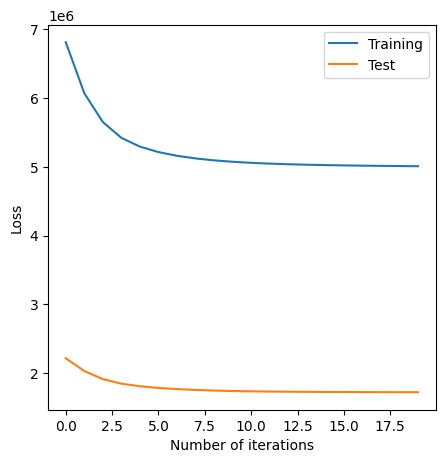

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_loss_history, label="Training")
ax.plot(list(range(num_epoch)), test_loss_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")
ax.legend()
# ax.title("Pos regularized log loss for biases+user and ")
plt.savefig("reg_pos_log_loss_biases_with.pdf", format="pdf", bbox_inches="tight")
plt.show()

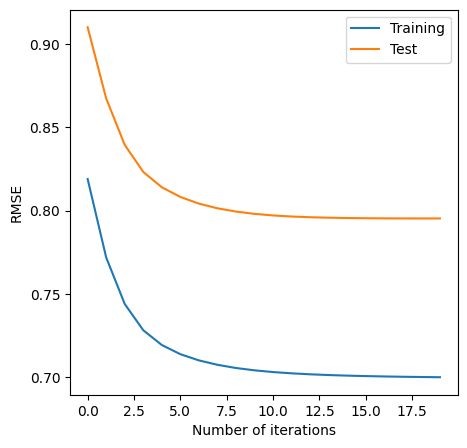

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_rmse_history, label="Training")
ax.plot(list(range(num_epoch)), test_rmse_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("RMSE")
ax.legend()
# ax.title("RMSE for biases+users and items")
plt.savefig("reg_rmse_for_biases_with.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# for m in [1,15, 100, 123, 150,194,201]:
#   print(f"User {id_to_user[m]} :")
#   n = test_data_by_user[m][0][1]
#   print("\tTrue rate : ",test_data_by_user[m][1][1])
#   print("\tPredicted rate : ", np.dot(user_vec[m].T, item_vec[n].T)+user_biases[m]+item_biases[n])

# Saving the model

In [ ]:
# user_vec = np.load("model_18/user_vec.npy")
# item_vec = np.load("model_18/item_vec.npy")
# user_biases = np.load("model_18/user_biases.npy")
# item_biases = np.load("model_18/item_biases.npy")
# train_loss_history = np.load("model_18/train_loss_history.npy")
# train_rmse_history = np.load("model_18/train_rmse_history.npy")
# test_loss_history = np.load("model_18/test_loss_history.npy")
# test_rmse_history = np.load("model_18/test_rmse_history.npy")

In [ ]:
#@title Save my model
# %mkdir model_amls
# %mkdir model_amls/datasets
import pickle

%mkdir /content/model_amls_18_p3_1/

path = "/content/model_amls_18_p3_1/"

with open(path+"params.txt", "w") as file:
    file.write(f"K = {K}\nlambd={lambd}\ngamma={gamma}\ntau={tau}\nnum_epoch = {num_epoch}")

with open(path+"user_vec.txt", "wb") as f:
  pickle.dump(user_vec, f)
  print("user_vec saved...")

with open(path+"item_vec.txt", "wb") as f:
  pickle.dump(item_vec, f)
  print("item_vec saved...")

with open(path+"user_biases.txt", "wb") as f:
  pickle.dump(user_biases, f)
  print("user_biases saved...")

with open(path+"item_biases.txt", "wb") as f:
  pickle.dump(item_biases, f)
  print("item_biases saved...")

with open(path+"train_loss_history.txt", "wb") as f:
  pickle.dump(train_loss_history, f)
  print("train_loss_history saved...")

with open(path+"test_loss_history.txt", "wb") as f:
  pickle.dump(test_loss_history, f)
  print("test_loss_history saved...")

with open(path+"train_rmse_history.txt", "wb") as f:
  pickle.dump(train_rmse_history, f)
  print("train_rmse_history saved...")

with open(path+"test_rmse_history.txt", "wb") as f:
  pickle.dump(test_rmse_history, f)
  print("test_rmse_history saved...")


!zip -r /content/model_amls_18_p3_1.zip /content/model_amls_18_p3_1

print("done...")

mkdir: cannot create directory ‘/content/model_amls_18_p3_1/’: File exists
user_vec saved...
item_vec saved...
user_biases saved...
item_biases saved...
train_loss_history saved...
test_loss_history saved...
train_rmse_history saved...
test_rmse_history saved...
  adding: content/model_amls_18_p3_1/ (stored 0%)
  adding: content/model_amls_18_p3_1/user_vec.txt (deflated 4%)
  adding: content/model_amls_18_p3_1/item_vec.txt (deflated 12%)
  adding: content/model_amls_18_p3_1/test_rmse_history.txt (deflated 44%)
  adding: content/model_amls_18_p3_1/train_rmse_history.txt (deflated 43%)
  adding: content/model_amls_18_p3_1/user_biases.txt (deflated 7%)
  adding: content/model_amls_18_p3_1/params.txt (stored 0%)
  adding: content/model_amls_18_p3_1/test_loss_history.txt (deflated 43%)
  adding: content/model_amls_18_p3_1/item_biases.txt (deflated 13%)
  adding: content/model_amls_18_p3_1/train_loss_history.txt (deflated 43%)
done...


In [ ]:
from google.colab import files
files.download("/content/model_amls_18_p3_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction

In [ ]:
#@title Load model

import pickle

# !unzip model_amls_18_3.zip

!unzip model_amls_18_30epoch_mai.zip

path = "model_amls_18_30epoch_mai/"

with open(path+"user_vec.txt", "rb") as f:
  user_vec = pickle.load(f)

with open(path+"item_vec.txt", "rb") as f:
  item_vec = pickle.load(f)

with open(path+"user_biases.txt", "rb") as f:
  user_biases = pickle.load(f)

with open(path+"item_biases.txt", "rb") as f:
  item_biases = pickle.load(f)

print("done...")

Archive:  model_amls_18_30epoch_mai.zip
replace model_amls_18_30epoch_mai/item_vec.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: None
done...


In [ ]:
movie_rated_more_than_20 = [n for n in range(N) if len(data_by_movie[n])>20]

In [ ]:
movie_rated_more_than_20 = [n for n in range(N) if len(data_by_movie[n])>20]
def sort_with_indices(lst):
  indexed_lst = list(enumerate(lst))
  indexed_lst.sort(key=lambda x: x[1], reverse=True)  # Sort based on the elements (x[1])
  sorted_indices = [x[0] for x in indexed_lst]  # Extract the sorted indices
  return sorted_indices

In [ ]:
#@title Dummpy user
#get a movie id
#4993#2116#
movie_id = 122892#
rate = 5
# print()
K = 10
print(f"You rate this movie : {movies.iloc[np.where(movies['movieId'].values == movie_id)[0][0]].title}")
#train a dummpy user
new_user = np.zeros(K)
r_m = np.array([rate])
movie_indices = [movie_to_id[movie_id]]
for epoch in range(num_epoch):
  #   numerator = np.sum(r_m - np.dot(new_user, item_vec[movie_indices,:].T)-item_biases[movie_indices])
  #   user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
  term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
  term2 = r_m - item_biases[movie_indices]
  term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
  new_user = linalg.solve(term1, term2)



#Make Recommendation
#Compute the rates
score_for_item = np.array([np.dot(new_user, item_vec[n])+item_biases[n] for n in movie_rated_more_than_20])
# score_for_item = list(np.dot(item_vec[movie_rated_more_than_20,:], new_user) + 0.05*item_biases[movie_rated_more_than_20])
# print(score_for_item.shape)
#Compute some recommendations
# print(score_for_item[recommendations[0]])
# #Sort the score_for_item and their indices
recommendations = sort_with_indices(score_for_item)[:20]#[np.where(movies["movieId"].values == id_to_movie[idx])[0][0] for idx in recommendation_idx]
# #  and get the indices of 20 best rates
# recommended_movies = list(np.array(movie_rated_more_than_20)[recommendations])
recommended_movies = [movie_rated_more_than_20[n] for n in recommendations]
# #Looking for the original indices of these movies
recommended_movies = [np.where(movies["movieId"].values == id_to_movie[idx])[0][0] for idx in recommended_movies]
# print(recommended_movies)
# #Print the thecommendation
movies.iloc[recommended_movies]

You rate this movie : Avengers: Age of Ultron (2015)


,movieId,title,genres
25068,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi
25067,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
25071,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller
17067,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
21348,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX
25069,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi
25058,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
25074,122926,Untitled Spider-Man Reboot (2017),Action|Adventure|Fantasy
49883,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi
25064,122906,Black Panther (2017),Action|Adventure|Sci-Fi


# Training biases

In [ ]:
#@title Training v2.1

#hyperparameters
K  = 10#60#40
lambd = 1#5
gamma = 0.01#0.2#0.15
tau = 1#0.2#0.15
num_epoch = 10#20

#Initialization
user_vec = np.zeros((M,K))
user_biases = np.zeros(M)
item_vec = np.zeros((N,K))
item_biases = np.zeros(N)
##

##
train_loss_history = []
test_loss_history = []
train_rmse_history = []
test_rmse_history = []

##
for epoch in tqdm(range(num_epoch)):
  #user biases
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    numerator = np.sum(r_m - np.dot(user_vec[m].T, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
  #item biases
  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    numerator = np.sum(r_n -np.dot(user_vec[user_indices,:], item_vec[n].T) -user_biases[user_indices])
    item_biases[n] = lambd*numerator/(lambd*len(r_n)+gamma)
  #Loss
  loss, rmse = loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  train_loss_history.append(loss.copy())
  train_rmse_history.append(rmse.copy())
  test_loss, test_rmse = loss_func(test_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  test_loss_history.append(test_loss.copy())
  test_rmse_history.append(test_rmse.copy())

100%|██████████| 10/10 [15:40<00:00, 94.08s/it]


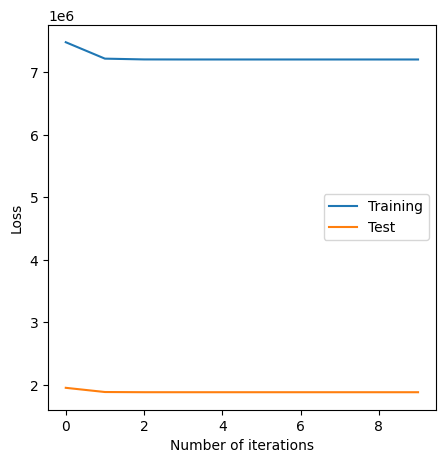

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_loss_history, label="Training")
ax.plot(list(range(num_epoch)), test_loss_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")
ax.legend()
# ax.title("Pos regularized log loss for biases+user and ")
plt.savefig("pos_log_loss_biases.pdf", format="pdf", bbox_inches="tight")
plt.show()

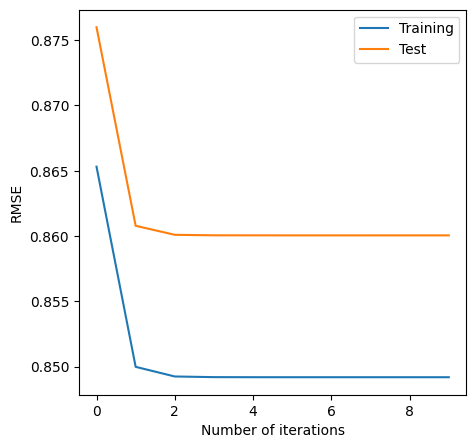

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_rmse_history, label="Training")
ax.plot(list(range(num_epoch)), test_rmse_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("RMSE")
ax.legend()
# ax.title("RMSE for biases+users and items")
plt.savefig("rmse_for_biases.pdf", format="pdf", bbox_inches="tight")
# plt.show()

#Polarization

In [ ]:
norms = np.linalg.norm(item_vec, axis=1)

most_polarized = np.argmax(norms)

least_polarized = np.argmin(norms)
print(type(most_polarized))
most_mv = movies.iloc[list(np.where(movies["movieId"].values == id_to_movie[most_polarized])[0])]["title"].values[0]
print("The movie the most polarized is : ",most_mv)
least_mv = movies.iloc[list(np.where(movies["movieId"].values == id_to_movie[least_polarized])[0])]["title"].values[0]
print("The movie the least polarized is : ",least_mv)

<class 'numpy.int64'>
The movie the most polarized is :  Room, The (2003)
The movie the least polarized is :  Nyrölä 3 (2004)


In [ ]:
most_polarized = (-norms).argsort()[:4]

movies_vec = item_vec[most_polarized,:]
idx = [id_to_movie[n] for n in most_polarized]
# movies.iloc[idx]

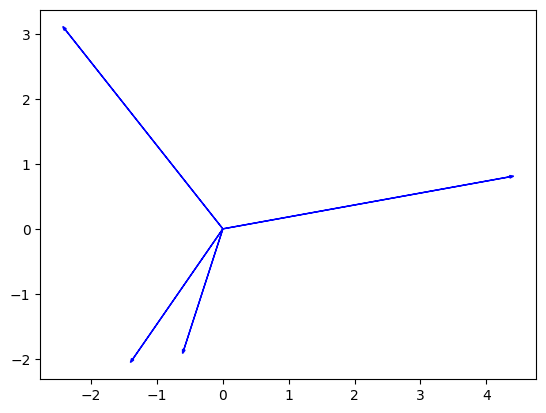

In [ ]:
pca = PCA(n_components=2)
movies_vec = pca.fit_transform(movies_vec)
for i in range(4):
  plt.arrow(0,0, movies_vec[i,0], movies_vec[i,1], head_width=0.04, color="blue")
# plt.scatter(movies_vec[:,0], movies_vec[:,1])

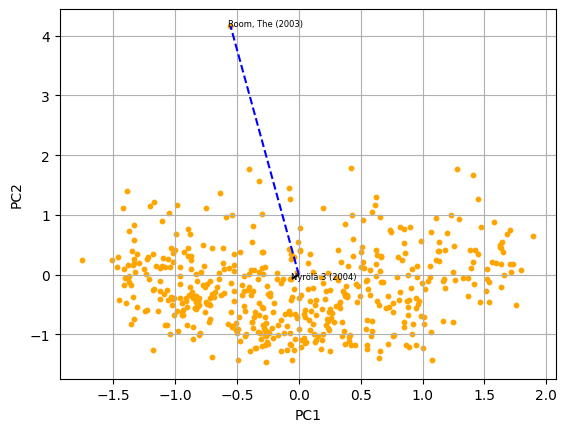

In [ ]:
from sklearn.decomposition import PCA
#
pca = PCA(n_components=2)
projected_features = pca.fit_transform(item_vec)
# normalization of PC
X = np.vstack((projected_features[:500,[0,1]], projected_features[most_polarized,[0,1]].reshape(1,2), projected_features[least_polarized,[0,1]].reshape(1,2)))

plt.scatter(X[:,0], X[:,1], color="orange", s=10)
plt.plot([0, X[-2,0]], [0, X[-2,1]], "--b",)
plt.text(X[-2,0]-0.02, X[-2,1],f"{most_mv}", fontsize=6)
#
plt.plot([0, X[-1,0]], [0, X[-1,1]], "--k")
plt.text(X[-1,0], X[-1,1], f"{least_mv}", fontsize=6)
#axes
# plt.axvline(x=0, color='k')
# plt.axhline(y=0, color='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid("True")
plt.savefig("polarizing_movies.pdf", format="pdf", bbox_inches="tight")